# <span style="color:green"> Numerical Simulation Laboratory (NSL) </span>
## <span style="color:blue">  Numerical exercises 4</span>

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import seaborn as sns
import scipy
import glob
import matplotlib.colors as mcolors
import matplotlib.cm as cm

colors = sns.color_palette("hls", 8)   # Colors
title_size = 16                        # Size title
axis_size = 14                         # Size axis label
value_size = 10                        # Size values on axis
legend_size = 12                       # Size legend

## Exercise 04.1
### Assignment

The Molecular Dynamics / Monte Carlo (MD_MC) code we have provided compute the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, and the temperature, $T$.

Include the calculation of the pressure, $P$, inside your Molecular Dynamics code: block averages, progressive average values and progressive uncertainties.

Remember that, via the **virial theorem**, the pressure in a Lennard-Jones system can be estimated by means of:

$$ P = \rho k_B T + \frac{1}{3V} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48\epsilon \left[ \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^{12} - 
\frac{1}{2} \left(\frac{\sigma}{|\vec{r}_i -\vec{r}_j|}\right)^6 \right] \right\rangle $$

### Resolution

I converted the previous equation of the pressure using the reduce units:

$$ P^* = \rho^{*}T^{*}+ \frac{1}{3V^*} \left\langle \sum_{i=1}^{N-1} \sum_{j\,(>i)}^N 48 \left[ \left(\frac{1}{|\vec{r}_i^* -\vec{r}_j^*|}\right)^{12} - \frac{1}{2} \left(\frac{1}{|\vec{r}_i^* -\vec{r}_j^*|}\right)^6 \right] \right\rangle $$

where $P^{*}=P\frac{\sigma^3}{\epsilon}, \ T^*=k_{B}\frac{T}{\epsilon}, \ V^*=\frac{V}{\epsilon}, \ \rho^*=\rho\sigma^3, \  r^*=\frac{r}{\sigma}$.


I implemented the previous equation in `void System :: measure()` method as follows:

```cpp
void System :: measure()
{
 // ... //
 if (_measure_penergy or _measure_pressure or _measure_gofr) 
 {
  for (int i=0; i<_npart-1; i++)
  {
   for (int j=i+1; j<_npart; j++)
   {
    distance(0) = this->pbc( _particle(i).getposition(0,true) - _particle(j).getposition(0,true), 0);
    distance(1) = this->pbc( _particle(i).getposition(1,true) - _particle(j).getposition(1,true), 1);
    distance(2) = this->pbc( _particle(i).getposition(2,true) - _particle(j).getposition(2,true), 2);
    dr = sqrt(dot(distance,distance));
    if(dr < _r_cut)
    {
     // ... //
     if(_measure_pressure) 
     pressure_temp += 1.0 / pow(dr,12) - 0.5 / pow(dr,6);	// PRESSURE
    }
   }
  }
 }
}
// ... //
if (_measure_pressure and _measure_temp) 
 _measurement(_index_pressure) = _rho * _measurement(_index_temp) +  48. * pressure_temp / (3. * _volume * double(_npart));
```	


## Exercise 04.2
### Assignment
By means of your upgraded code, perform MD simulations via a Lennard-Jones model of Argon ($\sigma = 0.34$ nm, $\epsilon/k_B = 120$ K, $m=39.948$ amu) in the following conditions:
1. solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
2. liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
3. gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)

and show in pictures the obtained progressive average values and uncertainties as a functions of the increasing number of blocks for the total (internal) energy per particle, $E/N$, the potential energy per particle, $U/N$, the kinetic energy per particle, $K/N$, the temperature, $T$, and the pressure, $P$, in reduced units!

####  Equilibration is needed!

By monitoring the temperature, $T$, during the first time steps of the simulation, you will observe that at the beginning, starting from a perfect crystalline configuration, $T$ will not conserve its value. Can you understand and explain this behaviour?

Explore and find the starting value of $T$ needed to stabilize, after a certain number of time steps (equilibration time), the average value of $T$ on the desired $T^\star$. Perform your solid/liquid phase MD simulations by re-starting them after such equilibration time.

### Resolution

**Molecular dynamics**

Microcanonical ensemble describes a system with a fixed number of particles, volume and energy (isolated system). Each microstate, having the same energy, has the same probability of being observed. By studying the microscopic properties of a system (positions and velocities of particles), it is possible to obtain some macroscopic properties (energy, pressure, temperature) thanks to statistical mechanics. Molecular dynamics (MD) simulations allow for the calculation of these properties by evolving the system through the solution of Newton's equations of motion.

In this exercise, we used **Verlet's algorithm**, a finite-difference method used to integrate equations of motion. It uses a third-order Taylor expansion of the position $\vec{r}(t)$ around $t \pm \delta t$, which gives:

$$ \vec{r}(t + \delta t) \sim 2\vec{r}(t) - \vec{r}(t-\delta t) + \delta t^2 \vec{a}(t)$$

where $\vec{a}(t)$ is the acceleration of the particles. This algorithm is a two-step method because it requires information from two different time instants. To compute the new positions, the algorithm does not directly use the velocity. Instead, the velocity is obtained from the knowledge of the trajectory:

$$ \vec{v}(t) \sim \frac{\vec{r}(t + \delta t) -\vec{r}(t - \delta t)}{2\delta t} $$

Periodic boundary conditions (PBC) are a widely used technique in MD simulations because they allow focusing on a small part of the system with a fixed number of particles confined in a box of finite dimensions that repeats itself indefinitely in all directions. This approach ensures that particles exiting the box from one side re-enter the box from the opposite side.

After a few steps, the temperature of the systems changes, deviating from the desired value. For the solid and liquid phases, the temperature decreases and stabilizes after 400 steps, while in the gas system, the temperature increases. This is due to the fact that the systems at the beginning aren't in an equilibrium state: they start in a specific configuration, evolve, and during this evolution, the particles change their velocity and consequently their kinetic energy and temperature.

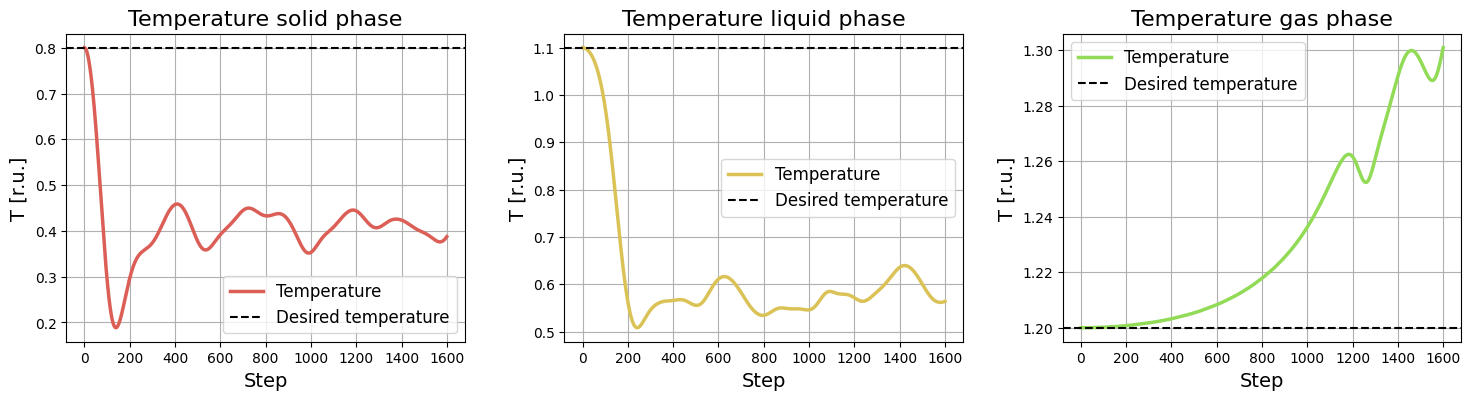

In [3]:
# Data paths
path = ['../E04/SOLID/', '../E04/LIQUID/', '../E04/GAS/']   # Paths
phase = ['solid', 'liquid', 'gas']                          # Phases
T = [0.8, 1.1, 1.2]                                         # Desired temperatures

# Plot
plt.figure(figsize=(18, 4))

for i in range(len(path)):      # Loop over the phases
    plt.subplot(1, 3, i + 1)
    df = pd.read_csv(path[i] + 'temp_step_eq.dat', sep=' ')     # Read data
    plt.plot(df['STEP'], df['TEMP'], color = colors[i], linewidth=2.5, label="Temperature")
    plt.axhline(T[i], color='black', linestyle='--', label="Desired temperature")
    plt.legend(fontsize=legend_size)
    plt.title('Temperature ' + phase[i] + ' phase', fontsize=title_size)
    plt.xlabel('Step', fontsize=axis_size)
    plt.ylabel('T [r.u.]', fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.grid(True)

plt.subplots_adjust(wspace = 0.25)
plt.show()

To determine the correct initial temperature for the simulation and achieve the desired temperatures, I created a function `double Equilibration_temp(...)`. This function takes the desired temperature as an input and performs a system simulation. It employs data blocking to calculate the mean and uncertainty of the temperature obtained from the simulation.

If the difference between the mean temperature and the desired temperature exceeds the uncertainty, the function starts a new simulation with a new temperature adjusted by adding or subtracting a value from the previous temperature. This value decreases by a factor of 10 each time the mean temperature surpasses the desired temperature, restarting the simulation from the previous temperature with the updated increment.

When the difference between the mean temperature and the desired temperature becomes smaller than the uncertainty, the function prints the coordinates and velocities of the system's particles to the files `config.xyz` and `velocities.in` respectively and returns the correct temperature with which to start the simulation.

I obtained:

- For the solid phase, to have at equilibrium a temperature of $T^*=0.8$, the starting temperature must be $T_i = 1.54$. I ran the simulations with $N_{blocks} = 50$ and $N_{step} = 1000$ for each system. 
- For the liquid phase, to have at equilibrium a temperature of $T^*=1.1$, the starting temperature must be $T_i = 2.0021$. I ran the simulations with $N_{blocks} = 100$ and $N_{step} = 2000$ for each system. 
- For the gas phase, to have at equilibrium a temperature of $T^*=1.2$, the starting temperature must be $T_i = 0.9779$. I ran the simulations with $N_{blocks} = 200$ and $N_{step} = 1000$ for each system. 

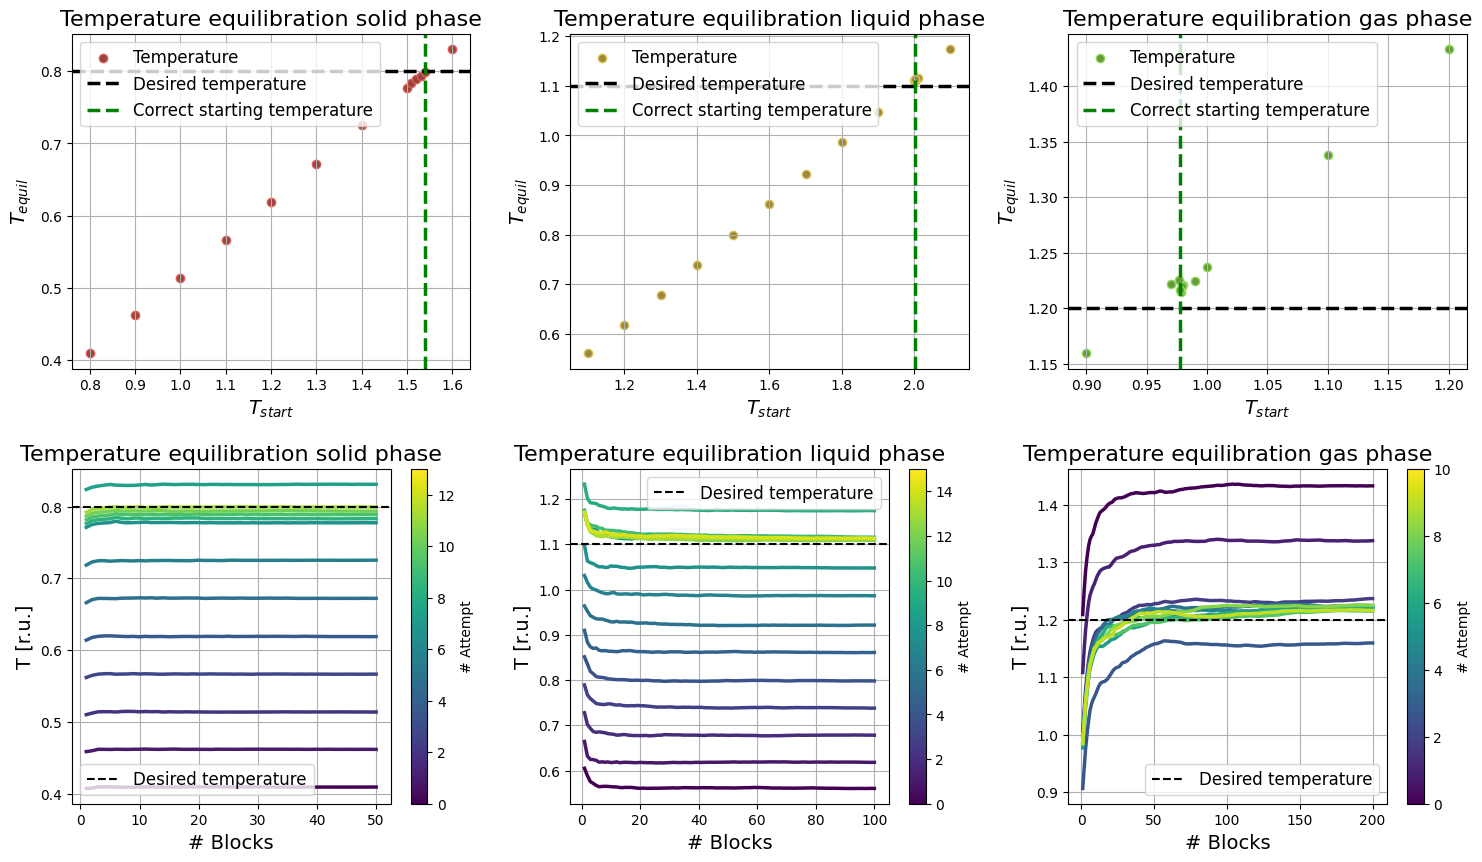

In [9]:
# Data paths
path = ['../E04/SOLID/EQUILIBRATION/OUTPUT/', '../E04/LIQUID/EQUILIBRATION/OUTPUT/', '../E04/GAS/EQUILIBRATION/OUTPUT/']  # Paths
phase = ['solid', 'liquid', 'gas']      # Phases
T = [0.8, 1.1, 1.2]                     # Desired temperatures

# Plot
plt.figure(figsize=(18, 10))

for i in range(len(path)):      # Loop over the phases
    # Scatter plot starting temperature vs equilibration temperature
    plt.subplot(2, 3, i + 1)
    df_t = pd.read_csv(path[i] + 'temp.dat', delimiter=' ')
    plt.scatter(df_t['T_i'], df_t['T_f'], color=colors[i], marker="o", facecolors=tuple(np.array(colors[i]) * 0.7), label="Temperature")
    plt.axhline(T[i], color='black', linestyle='--', linewidth=2.5, label="Desired temperature")  
    plt.axvline(df_t['T_i'][len(df_t) - 1], color='green', linestyle='--', linewidth=2.5, label="Correct starting temperature")
    plt.title("Temperature equilibration " + phase[i] + " phase", fontsize=title_size)
    plt.xlabel(r'$T_{start}$', fontsize=axis_size)
    plt.ylabel(r'$T_{equil}$', fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.legend(fontsize=legend_size)
    plt.grid(True)

    # Plot temperature equilibration
    ax = plt.subplot(2, 3, i + 4)
    file_list = glob.glob(path[i] + '*temperature.dat') # File list
    cmap = plt.get_cmap('viridis')                      # Colormap 
    norm = plt.Normalize(0, len(file_list) - 1)         # Normalize colormap
    for count, paths in enumerate(file_list):           # Loop over the files
        if count < len(df_t):
            df = pd.read_csv(path[i] + str(count).zfill(2) + 'temperature.dat', delimiter=' ')
            plt.plot(df['#BLOCK'], df['AVE'], color= cmap(count / len(file_list)), linewidth=2.5)
    plt.axhline(T[i], color='black', linestyle='--', label="Desired temperature")

    plt.title("Temperature equilibration " + phase[i] + " phase", fontsize=title_size)
    plt.xlabel(r'# Blocks', fontsize=axis_size)
    plt.ylabel(r"T [r.u.]", fontsize=axis_size)
    plt.tick_params(axis='both', which='major', labelsize=value_size)
    plt.legend(fontsize=legend_size)
    plt.grid(True)

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, orientation='vertical', label="# Attempt")
    
plt.subplots_adjust(wspace=0.25, hspace=0.3)
plt.show()


I used the correct starting temperatures obtained from the `double Equilibration_temp(...)` function to initialize the systems. By setting the parameter `RESTART` equal to 1 in the `input.dat` files, the initial coordinates and velocities of the particles were read from the `config.xyz` and `velocities.in` files. With the systems equilibrated, I ran a simulation with $N_{blocks} = 100$ and $N_{step} = 1000$ for each system with five blocks for equilibration.

The temperature in the solid system is compatible with the desired one, while in the liquid system, and especially in the gas system, the temperature deviates from the desired one due to the slower dynamics caused by the rare interactions between particles. For the same reason, in the gas system, the fluctuations are greater than in the other systems.
The behavior of the temperature and the kinetic energy is very similar because they are proportional to each other. 
The total energy per particle remains almost stable in all systems, as expected in a microcanonical ensemble. 


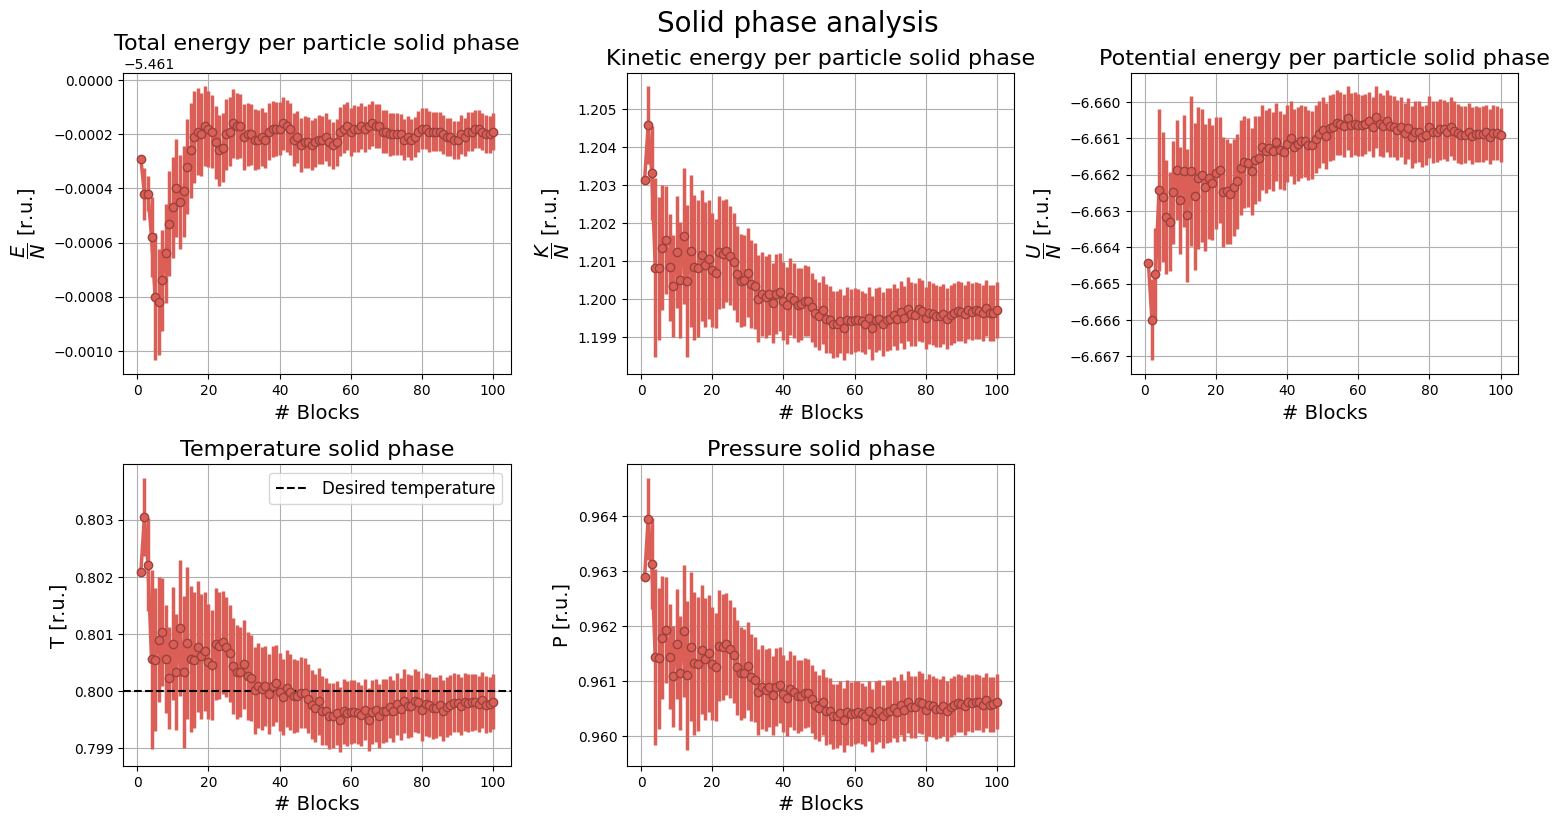

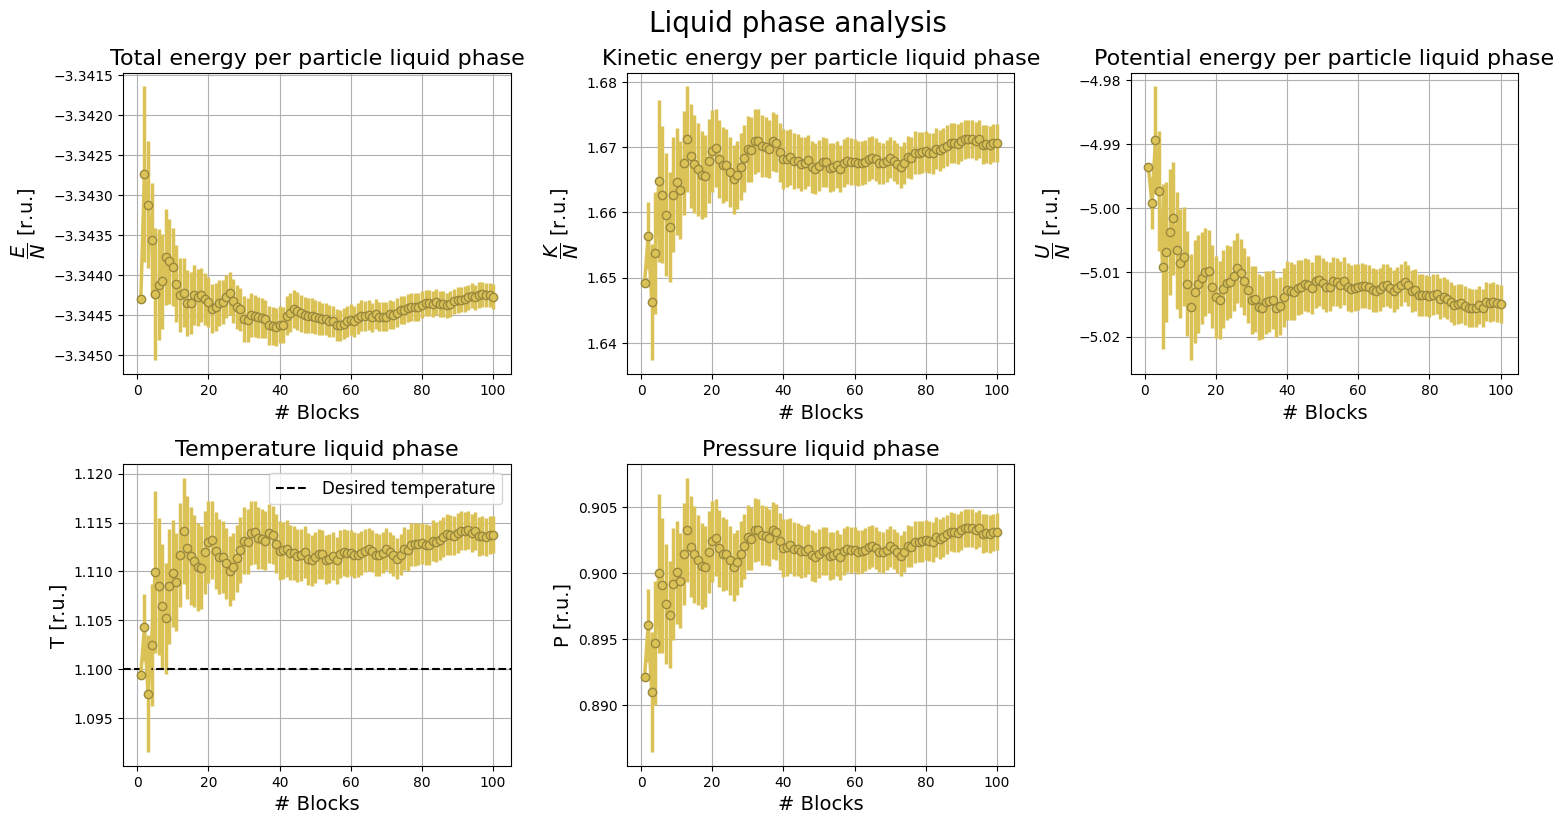

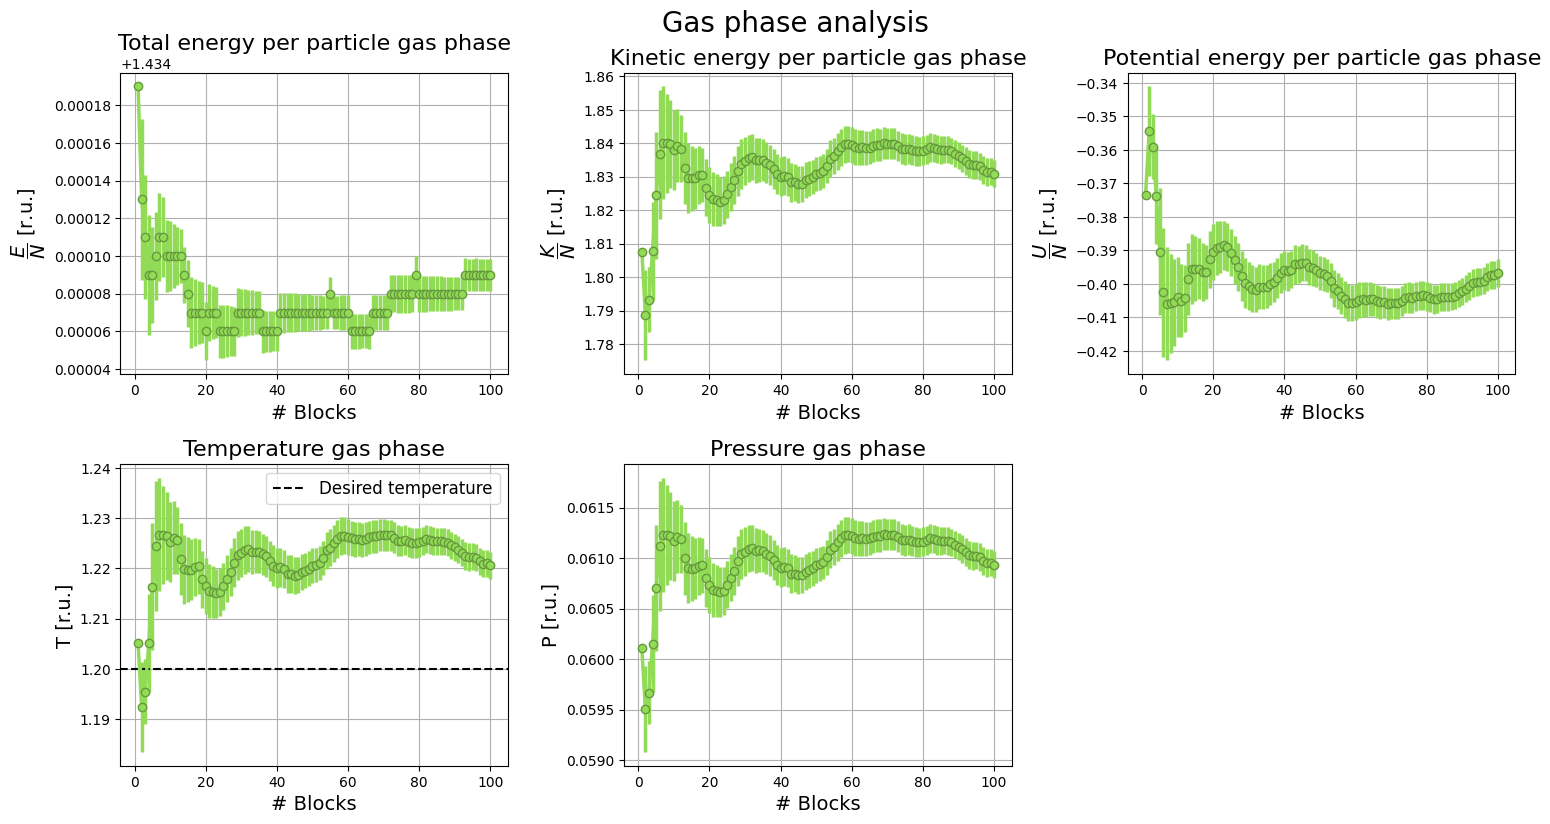

In [3]:
# Data paths
path = ['../E04/SOLID/SIMULATION/OUTPUT/', '../E04/LIQUID/SIMULATION/OUTPUT/', '../E04/GAS/SIMULATION/OUTPUT/']  # Paths
phase = ['solid', 'liquid', 'gas']  # Phases
axis_name = ['$\dfrac{E}{N}$ [r.u.]',r'$\dfrac{K}{N}$ [r.u.]', r'$\dfrac{U}{N}$ [r.u.]', r'T [r.u.]', r'P [r.u.]', r'T [r.u.]']     # Axis names
files = ['total_energy.dat', 'kinetic_energy.dat', 'potential_energy.dat', 'temperature.dat', 'pressure.dat'] # Files
title = ['Total energy per particle', 'Kinetic energy per particle', 'Potential energy per particle', 'Temperature', 'Pressure', 'Temperature by steps'] # Titles plot
T = [0.8, 1.1, 1.2]     # Desired temperatures

for i in range(len(path)):        # Loop over the phases

    plt.figure(figsize=(18, 9))
    
    for j in range(len(files)):   # Loop over the files     
        df = pd.read_csv(path[i] + files[j], delimiter=' ')
        plt.subplot(2, 3, j + 1)
        plt.errorbar(df['#BLOCK'], df['AVE'], yerr = df['ERROR'], color = colors[i], linewidth=2.5, marker='o', mec=tuple(np.array(colors[i]) * 0.7))
        if j == 3: 
            plt.axhline(T[i], color='black', linestyle='--', label="Desired temperature")
            plt.legend(fontsize=legend_size)
        plt.title(title[j].split('.')[0] + " " + phase[i] + " phase", fontsize=title_size)
        plt.xlabel(r'# Blocks', fontsize=axis_size)
        plt.ylabel(axis_name[j], fontsize=axis_size)
        plt.tick_params(axis='both', which='major', labelsize=value_size)
        plt.grid(True)

    plt.suptitle(f'{phase[i].capitalize()} phase analysis', fontsize=20, y=0.95)
    plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
